# COCS2673 Assignment 2 P1A - Is or is not cancer prediction

In [1]:
#!pip install tensorflow

In [2]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [3]:
#!pwd

In [4]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

tf.__version__

'2.4.1'

# Load Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
mainData = mainData.sample(2000)
#mainData = mainData.append(extraData, ignore_index=True)

# Exploratary Data Analysis (EDA)

In [7]:
print(mainData.dtypes)
#print(mainData.shape)
#print(mainData.info())
print(mainData.describe())


InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object
         InstanceID    patientID     cellType  isCancerous
count   2000.000000  2000.000000  2000.000000  2000.000000
mean    9977.741500    29.781500     1.484000     0.415500
std     6636.029949    17.468753     0.945088     0.492931
min        2.000000     1.000000     0.000000     0.000000
25%     4061.000000    14.000000     1.000000     0.000000
50%     9165.500000    26.000000     2.000000     0.000000
75%    16658.000000    47.000000     2.000000     1.000000
max    22437.000000    60.000000     3.000000     1.000000


Update Categorical Data types

In [8]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')


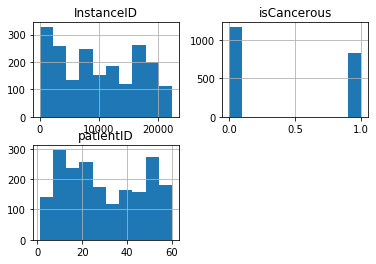

In [9]:
mainData.hist()
plt.show()

In [10]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


In [11]:
mainData['isCancerous'] = mainData['isCancerous'].astype('category')

#mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')
#mainData['cellType'] = mainData['cellType'].astype('category')

#? One hot encode cellType?


In [12]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8403 to 5051
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   patientID    2000 non-null   int64   
 1   ImageName    2000 non-null   object  
 2   isCancerous  2000 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 48.9+ KB


In [13]:
mainData.isnull().sum()

patientID      0
ImageName      0
isCancerous    0
dtype: int64

In [14]:
#for i, col in enumerate(mainData.columns):
#    print("==>", col)
#    print(mainData[col].value_counts())
#    print()

In [15]:
neg, pos = np.bincount(mainData.isCancerous)
total = neg + pos
print('Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Class Data:
    Total: 2000
    Positive: 831 (41.55% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)

Split of benign to cancerous is a 35% cancerous, 65% benign

Check all image files exist

In [16]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


# Train/Validation/Test Split on Patients

### Add classification class

In [17]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
- Check if a person has cancer or not, then would the images for that person have cancer?

In [18]:
# Get list of patients and observation counts
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [19]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [20]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [21]:
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])
#print(mainData.shape[0])
print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))

Train data : 1467, Val Data: 300, Test Data: 233


In [22]:
trainData.head()

,patientID,ImageName,isCancerous
899,7,9205.png,1
6318,40,8075.png,0
2157,13,4519.png,1
4467,23,20311.png,0
4739,25,17343.png,0


([0, 1], <a list of 2 Text xticklabel objects>)

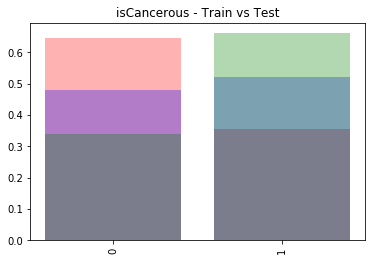

In [23]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')
plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')
plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')
plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

# Images
27x27 RGB 

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1467 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 233 validated image filenames belonging to 2 classes.


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1467 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 233 validated image filenames belonging to 2 classes.


### Utility Functions

In [36]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Models

## 1. Baseline an simple MLP Model
Observations
* Binary classification problem
* Simple 1 hidden layer - 256 nodes
* Loss - Binary Cross Entropy
* Metric - binary_accuracy ? Check if should/can use F1

* use sigmoid activation as this is a logistics issue

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

In [27]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

## Baseline
* Use a initial NN to get a baseline
* Input has 2187 dims
* 1 hidden layer with 256 internal nodes
* 1 output binary

In [28]:
import tensorflow as tf

model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='sigmoid')
])

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [30]:
# model.compile(optimizer='SGD',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['categorical_accuracy'])

#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=[tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)])

model1.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [31]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history1 = model1.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

19:43:36
19:45:25
Took =  0:01:48.330234


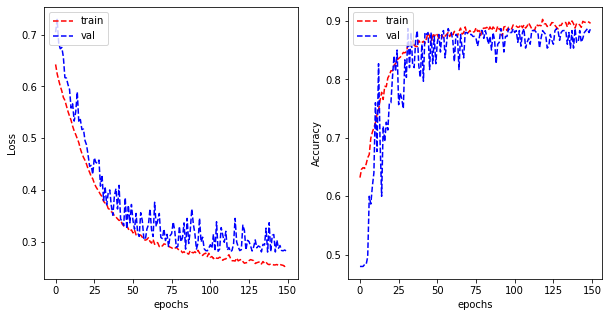

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], 'r--')
plt.plot(history1.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history1.history['binary_accuracy'], 'r--')
plt.plot(history1.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()


8/8 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        79
           1       0.00      0.00      0.00       154

    accuracy                           0.34       233
   macro avg       0.17      0.50      0.25       233
weighted avg       0.11      0.34      0.17       233



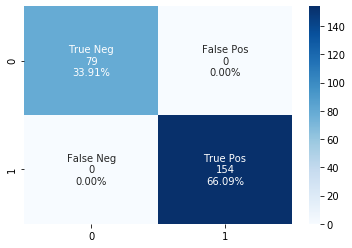

In [37]:
import seaborn as sn
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

test_y = testData['isCancerous'].astype('int')

test_pred = model1.predict(test_generator, batch_size=64, verbose=1)
test_pred = np.argmax(test_pred, axis=1)

print(classification_report(test_y, test_pred))

PlotConfusionMatrix(test_y, test_pred)

### Observation
* Train vs Validation approaches at 150 epocs
* There looks to be some overfitting
* Recall is good (?) maybe too good 
* Precision low low at 0.40
* F1 score low at 0.64

### Try some regularisation

In [38]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [39]:
model_reg.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [40]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [41]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)


19:49:35
19:50:59
Took =  0:01:23.880019


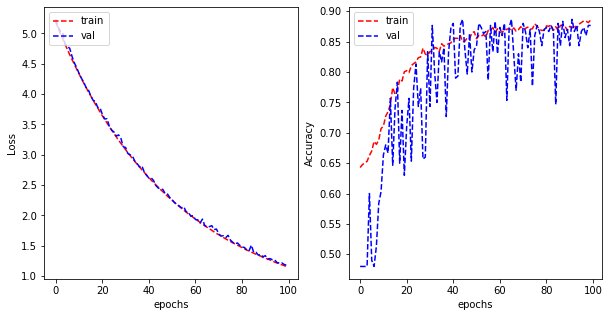

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['binary_accuracy'], 'r--')
plt.plot(history_reg.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()


8/8 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        79
           1       0.00      0.00      0.00       154

    accuracy                           0.34       233
   macro avg       0.17      0.50      0.25       233
weighted avg       0.11      0.34      0.17       233



C:\bin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


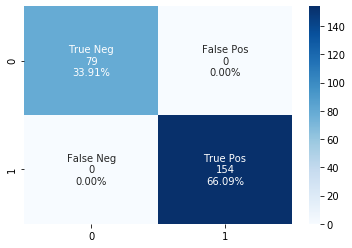

In [43]:
test_pred_r = model_reg.predict(test_generator, batch_size=64, verbose=1)
test_pred_r = np.argmax(test_pred_r, axis=1)

print(classification_report(test_y, test_pred_r))

PlotConfusionMatrix(test_y, test_pred_r)

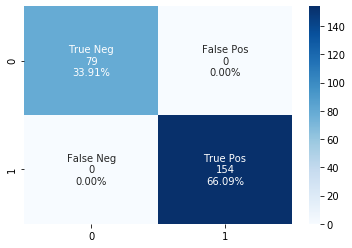

In [44]:
PlotConfusionMatrix(test_y, test_pred_r)

### Try some dropout

In [45]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [46]:
model_drop.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [47]:
model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [48]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

19:51:25
19:53:11
Took =  0:01:45.919008


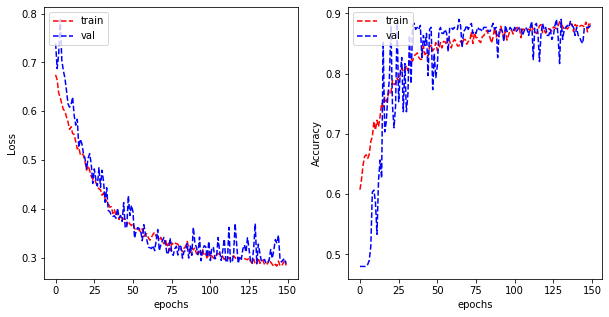

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['binary_accuracy'], 'r--')
plt.plot(history_drop.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

plt.show()


Also improves but test data looks to be better than training

8/8 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        79
           1       0.00      0.00      0.00       154

    accuracy                           0.34       233
   macro avg       0.17      0.50      0.25       233
weighted avg       0.11      0.34      0.17       233



C:\bin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


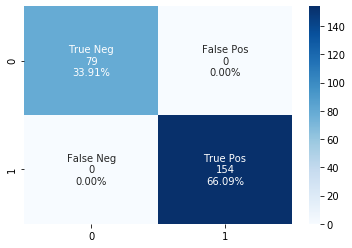

In [50]:
test_pred = model_drop.predict(test_generator, batch_size=64, verbose=1)
test_pred = np.argmax(test_pred, axis=1)

print(classification_report(test_y, test_pred))

PlotConfusionMatrix(test_y, test_pred_r)

## 2. Baseline Plus VGG

In [51]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [52]:
model_VGG_1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [53]:
model_VGG_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

19:53:12


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_VGG_1.history['loss'], 'r--')
plt.plot(history_VGG_1.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_VGG_1.history['binary_accuracy'], 'r--')
plt.plot(history_VGG_1.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

plt.show()


In [ ]:
test_pred = model_VGG_1.predict(test_generator, batch_size=64, verbose=1)
test_pred = np.argmax(test_pred, axis=1)

print(classification_report(test_y, test_pred))

## VGG 2
Observations

Issue is over fitting 
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [ ]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [ ]:
model_VGG_2.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
model_VGG_2.summary()

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_VGG_2.history['loss'], 'r--')
plt.plot(history_VGG_2.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_VGG_2.history['binary_accuracy'], 'r--')
plt.plot(history_VGG_2.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
test_pred = model_VGG_2.predict(test_generator, batch_size=64, verbose=1)
test_pred = np.argmax(test_pred, axis=1)

print(classification_report(test_y, test_pred))

In [ ]:
# errrrrr